In [37]:
import pandas as pd
import yfinance as yf
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.dates as mdates
# import ace_tools as tools; 

# 配置中文字体
plt.rcParams['font.family'] = 'Heiti TC'

# plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['figure.dpi'] = 150
plt.rcParams.update({'font.size': 12})

In [38]:
def get_stock_data(stock_symbols, start_date, end_date):
    stock_data = {}
    for symbol in stock_symbols:
        stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

def get_stock_price(stock_symbols, start_date, end_date):
    stock_data = {}
    for symbol in stock_symbols:
        stock_data[symbol] = yf.download(symbol, start=start_date, end=end_date)['Adj Close']
    return pd.DataFrame(stock_data)

def calculate_moving_average(stock_prices, short_window, long_window):
    short_ma = stock_prices.rolling(window=short_window).mean()
    long_ma = stock_prices.rolling(window=long_window).mean()
    return short_ma, long_ma

# Calculate Z-score for mean reversion
def calculate_z_score(stock_prices, window):
    rolling_mean = stock_prices.rolling(window=window).mean()
    rolling_std = stock_prices.rolling(window=window).std()
    z_score = (stock_prices - rolling_mean) / rolling_std
    return z_score

# Adjust Threshold Dynamically
def dynamic_threshold(SSINDX, window):
    std_SSINDX = (SSINDX - SSINDX.mean())/SSINDX.std()
    rolling_std = std_SSINDX.rolling(window).std()
    return 2.5 + 2 * rolling_std

# Portfolio optimization
def portfolio_optimization(returns, cov_matrix):
    num_assets = len(returns)

    def objective(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))
    
    def constraint(weights):
        return np.sum(weights) - 1

    cons = ({'type': 'eq', 'fun': constraint})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(objective, num_assets * [1. / num_assets,], bounds=bounds, constraints=cons)
    
    return result.x

# Calculate max drawdown
def calculate_max_drawdown(portfolio_values):
    cumulative_max = np.maximum.accumulate(portfolio_values)
    drawdown = (cumulative_max - portfolio_values) / cumulative_max
    max_drawdown = np.max(drawdown) * 100
    return max_drawdown

# Summarize PnL analysis
def pnl_summary(portfolio_values, dates, buy_count, sell_count):
    df = pd.DataFrame({'Date': dates, 'Portfolio Value': portfolio_values})
    df.set_index('Date', inplace=True)
    df['Return'] = df['Portfolio Value'].pct_change()
    df['Year'] = df.index.year

    summary = df.groupby('Year').agg({
        'Portfolio Value': ['first', 'last'],
        'Return': ['std']
    })
    summary.columns = ['Start Value', 'End Value', 'Return Std']
    summary['Annual Return %'] = ((summary['End Value'] / summary['Start Value']) - 1) * 100
    summary['Sharpe Ratio'] = summary['Annual Return %']  / (summary['Return Std'] * np.sqrt(252) * 100)
    
    # Calculate Max Drawdown per year
    max_drawdowns = []
    for year in summary.index:
        year_values = df[df['Year'] == year]['Portfolio Value']
        max_drawdowns.append(calculate_max_drawdown(year_values.values))

    summary['Max Drawdown %'] = max_drawdowns
    summary['Buy Count'] = buy_count
    summary['Sell Count'] = sell_count
    
    # Round to 2 decimal places
    summary = summary.round(2)

    return summary

# Summarize total PnL analysis
def pnl_summary_total(portfolio_values, dates):
    df = pd.DataFrame({'Date': dates, 'Portfolio Value': portfolio_values})
    df.set_index('Date', inplace=True)
    df['Return'] = df['Portfolio Value'].pct_change()

    total_return = ((df['Portfolio Value'][-1] / df['Portfolio Value'][0]) - 1) * 100
    sharpe_ratio = df['Return'].mean() / df['Return'].std() * np.sqrt(252)
    max_drawdown = calculate_max_drawdown(df['Portfolio Value'].values)

    summary_total = pd.DataFrame({
        'Total Return %': [total_return],
        'Sharpe Ratio': [sharpe_ratio],
        'Max Drawdown %': [max_drawdown]
    })

    # Round to 2 decimal places
    summary_total = summary_total.round(2)

    return summary_total

In [39]:
#### 按照排序分配权重的策略
# 初始分配权重
def initial_weights(stock_symbols):
    num_stocks = len(stock_symbols)
    return np.ones(num_stocks) / num_stocks

# 重新分配权重
def rebalance_weights(z_scores, date, initial_weight):
    ranked_stocks = z_scores.loc[date].sort_values()
    num_stocks = len(ranked_stocks)
    new_weights = np.zeros(num_stocks)
    
    # 根据排序结果重新分配权重
    for i, stock in enumerate(ranked_stocks.index):
        new_weights[i] = initial_weight * (1 + ranked_stocks.index.get_loc(stock) / num_stocks)
    new_weights /= new_weights.sum()  # 归一化权重

    return new_weights

def rebalance_rank_portfolio(stock_prices, window, initial_capital):
    transaction_cost=0.005
    lot_size=100
    min_trade_volume = 200
    z_scores = calculate_z_score(stock_prices, window)
    
    num_stocks = len(stock_prices.columns)
    initial_weight = 1 / num_stocks
    weights = initial_weights(stock_prices.columns)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros(num_stocks)
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    positions[0] = current_positions
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year

    for t, date in enumerate(stock_prices.index[window:], start=1):
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score排序重新分配权重
        new_weights = rebalance_weights(z_scores, date, initial_weight)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1

        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
        
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count

In [40]:

def rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma=None, long_ma=None):
    lot_size=100
    transaction_cost = 0.005
    min_trade_volume = 100
    
    num_stocks = len(stock_prices.columns)
    z_scores = calculate_z_score(stock_prices, window)
    cov_matrix = stock_prices.pct_change().cov()
    mean_returns = stock_prices.pct_change().mean()
    dynamic_thresholds = dynamic_threshold(SSINDX, window)

    weights = portfolio_optimization(mean_returns, cov_matrix)
    portfolio_value = initial_capital
    portfolio_values = [initial_capital]
    positions = np.zeros((len(stock_prices.index[window-1:]), num_stocks))  # 存储每个交易日的仓位
    adjustments = np.zeros_like(positions)  # 存储每个交易日的调整信号
    current_positions = np.zeros(num_stocks)
    cash = initial_capital
    buy_count = []
    sell_count = []
    annual_buy_count = 0
    annual_sell_count = 0
    current_year = stock_prices.index[window].year
    
    positions[0] = current_positions

    for t, date in enumerate(stock_prices.index[window:], start=1):
        # 获取当前交易日的动态阈值
        threshold = dynamic_thresholds.loc[date]
        if date.year != current_year:
            buy_count.append(annual_buy_count)
            sell_count.append(annual_sell_count)
            annual_buy_count = 0
            annual_sell_count = 0
            current_year = date.year
        
        # 根据Z-score和趋势调整权重
        new_weights = np.zeros(len(weights))
        for i, stock in enumerate(stock_prices.columns):
            if short_ma[stock].loc[date] > long_ma[stock].loc[date]:  # 确保在多头市场
                if z_scores[stock].loc[date] < -threshold:
                    new_weights[i] = weights[i] + 0.05
                elif z_scores[stock].loc[date] > threshold:
                    new_weights[i] = weights[i] - 0.05
                else:
                    new_weights[i] = weights[i]
            else:
                new_weights[i] = weights[i]  # 保持不变
                
        
        new_weights = np.clip(new_weights, 0, 1)
        new_weights = new_weights / np.sum(new_weights)
        
        # 根据新的权重进行买卖股票
        for i, stock in enumerate(stock_prices.columns):
            current_price = stock_prices[stock].loc[date]
            desired_position = portfolio_value * new_weights[i] // current_price
            
            # 检查交易量是否达到最低交易量限制
            trade_volume = abs(desired_position - current_positions[i]) * current_price
            if trade_volume < min_trade_volume:
                continue  # 如果交易量小于最低限制，则跳过此交易
            
            if desired_position > current_positions[i]:
                buy_amount = (desired_position - current_positions[i]) // lot_size * lot_size
                if buy_amount > 0 and cash >= buy_amount * current_price * (1 + transaction_cost):
                    current_positions[i] += buy_amount
                    cash -= buy_amount * current_price * (1 + transaction_cost)
                    annual_buy_count += 1
                    adjustments[t, i] = 1 # 买入信号
            elif desired_position < current_positions[i]:
                sell_amount = (current_positions[i] - desired_position) // lot_size * lot_size
                if sell_amount > 0:
                    current_positions[i] -= sell_amount
                    cash += sell_amount * current_price * (1 - transaction_cost)
                    annual_sell_count += 1
                    adjustments[t, i] = -1  # 卖出信号
            else: adjustments[t, i] = 0  # 卖出信号
    
        weights = new_weights
        portfolio_value = cash + np.sum(current_positions * stock_prices.loc[date])
        portfolio_values.append(portfolio_value)
        positions[t] = current_positions  # 记录仓位
    
    buy_count.append(annual_buy_count)
    sell_count.append(annual_sell_count)

    return portfolio_values, weights, positions, adjustments, buy_count, sell_count


In [41]:
# 读取Excel文件
df = pd.read_excel('Stocks.xlsx', sheet_name='Holdlist')

# 获取股票代码列表
stock_symbols = df['Stock Symbol'].tolist()
stock_names = df['Stock Name'].tolist()

# 定义时间范围
start_date = '2024-05-01'
end_date = '2024-08-11'

# 设置参数
initial_capital = 40000
window = 10
threshold = 2.5
transaction_cost = 0.005  # 假设交易成本为0.5%
rebalance_period = 7  # 调仓周期为3天

stock_data = get_stock_price(stock_symbols, start_date, end_date)
# 获取上证指数数据
SSINDX = yf.download('000001.SS', start=start_date, end=end_date)['Close']

# Ensure stock_data is a DataFrame and handle any missing values
stock_prices = pd.DataFrame(stock_data).ffill().bfill()
dates = stock_prices.index[window-1:]
short_window = 40
long_window = 200
short_ma, long_ma = calculate_moving_average(stock_prices, short_window, long_window)

# 调整rebalance_portfolio函数的调用
portfolio_values, weights, positions, adjustments, buy_count, sell_count = rebalance_portfolio(stock_prices, SSINDX, window, initial_capital, short_ma, long_ma)
portfolio_values1, weights1, positions1, adjustments1, buy_count1, sell_count1 = rebalance_rank_portfolio(stock_prices=stock_prices, window=window, initial_capital=initial_capital)
print(f'Final Portfolio Value: {portfolio_values[-1]}')
print(f'Final Portfolio Value: {portfolio_values1[-1]}')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Final Portfolio Value: 38000.1115732193
Final Portfolio Value: 37778.3071295619


In [42]:
# Total PnL Summary
summary_total = pnl_summary_total(portfolio_values, dates)
summary_total

/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_91667/3691211594.py:90: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,Total Return %,Sharpe Ratio,Max Drawdown %
0,-5.0,-1.24,8.95


In [43]:
summary_total1 = pnl_summary_total(portfolio_values1, dates)
summary_total1

/var/folders/2h/657ql8s954s35xlylnvyhmrw0000gn/T/ipykernel_91667/3691211594.py:90: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



,Total Return %,Sharpe Ratio,Max Drawdown %
0,-5.55,-1.51,7.86


In [44]:
# PnL Summary of Portfolio Optimization
summary = pnl_summary(portfolio_values, dates, buy_count, sell_count)
summary

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2024,40000.0,38000.11,0.01,-5.0,-0.3,8.95,26,5


In [45]:
# PnL Summary of Rank Method
summary1 = pnl_summary(portfolio_values1, dates, buy_count1, sell_count1)
summary1

,Start Value,End Value,Return Std,Annual Return %,Sharpe Ratio,Max Drawdown %,Buy Count,Sell Count
Year,,,,,,,,
2024,40000.0,37778.31,0.01,-5.55,-0.36,7.86,21,2


### PnL Visualization

In [46]:
# Interactive Plot for Portfolio Value
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=portfolio_values, mode='lines', name='Portfolio Value'))
fig.update_layout(title='Portfolio Value Over Time', xaxis_title='Date', yaxis_title='Portfolio Value')
fig.show()

In [47]:
# Interactive Plot for Portfolio Value
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=portfolio_values1, mode='lines', name='Portfolio Value'))
fig.update_layout(title='Portfolio Value Over Time', xaxis_title='Date', yaxis_title='Portfolio Value')
fig.show()

### Visualization

In [48]:
# 历史仓位的堆积面积图
def plot_historical_positions(dates, positions, stock_names, stock_prices):
    dates = dates[1:]
    # 计算每个股票价值
    stock_values = positions[1:] * stock_prices[window:]
    # print(stock_values)
    
    # 计算总资产
    total_portfolio_value = stock_values.sum(axis=1).values.reshape(-1, 1)  # 移除 keepdims 并调整形状
    
    # 计算每个股票在总资产中的权重
    positions_weight = stock_values / total_portfolio_value * 100
   # 累积求和以形成堆积图效果
    cumulative_weights = np.cumsum(positions_weight, axis=1)
    fig = go.Figure()

    # 创建堆积面积图
    for i, stock in enumerate(stock_names):
        fig.add_trace(go.Scatter(
            x=dates,
            y=cumulative_weights.iloc[:, i],
            mode='none',  # 不显示线，只显示堆积部分
            fill='tonexty' if i > 0 else 'tozeroy',  # 第一个是从零开始填充，后面的堆积在前面的基础上
            name=stock,
            hoverinfo='text',  # 使用自定义的 hover 信息
            text=[f"{stock}: {p:.2f}%" for p in positions_weight.iloc[:, i]],  # 生成每个点的具体信息
            hovertemplate="%{text}<extra></extra>"  # 显示自定义的文本信息
        ))
    
    fig.update_layout(
        title="Historical Stock Positions Over Time",
        xaxis_title="Date",
        yaxis_title="Position Percentage (%)",
        yaxis=dict(range=[0, 100]),  # 确保Y轴从0到100%
        showlegend=True,
        hovermode="x unified"  # 使得悬停时显示统一的标签框
    )
    
    fig.show()
    
# 当前仓位的饼图
def plot_current_positions(weights, stock_names, threshold=0.03):
    # 合并小份额
    other_weight = 0
    filtered_weights = []
    filtered_symbols = []
    for weight, symbol in zip(weights, stock_names):
        if weight < threshold:
            other_weight += weight
        else:
            filtered_weights.append(weight)
            filtered_symbols.append(symbol)
    
    if other_weight > 0:
        filtered_weights.append(other_weight)
        filtered_symbols.append("Other")
    
    fig = go.Figure(data=[go.Pie(
        labels=filtered_symbols,
        values=filtered_weights,
        textinfo='label+percent',
        hoverinfo='label+percent+value',
        textfont=dict(size=12),
        hole=0.3  # 如果你想要甜甜圈图效果
    )])
    
    fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
    
    fig.update_layout(
        title_text="Current Portfolio Positions",
        annotations=[dict(text='Portfolio', x=0.5, y=0.5, font_size=15, showarrow=False)]
    )
    
    fig.show()
  
# 仓位调整提示的热力图
def plot_adjustment_heatmap(dates, adjustments, stock_names):
    disp_dates = pd.to_datetime(dates[-30:])
    disp_adjustments = adjustments[-30:]
    
    # 设置图像大小
    plt.figure(figsize=(12, 8))
    # 创建热力图
    sns.heatmap(disp_adjustments.T, cmap="coolwarm", center=0, linewidths=0.1, linecolor='black', 
                cbar_kws={'label': 'Adjustment Signal'}, yticklabels=stock_names, xticklabels=disp_dates.strftime('%m-%d'))
    
    plt.title("Position Adjustment Signals Over Last 30 Days")
    plt.xlabel("Date")
    plt.ylabel("Stock Symbol")
   
    plt.show()
    
# 仓位调整表格
def display_position_table(stock_symbols, final_weights, adjustments):
    print(len(stock_symbols))
    print(len(final_weights))
    print(len(adjustments[-1]))
    data = {
        "Stock Symbol": stock_symbols,
        "Current Position": final_weights,
        "Adjustment Signal": adjustments[-1]  # 显示最新的调整信号
    }
    df = pd.DataFrame(data)
    print(df)    

In [49]:
plot_historical_positions(dates, positions, stock_names, stock_prices)

In [50]:
plot_historical_positions(dates, positions1, stock_names, stock_prices)

In [51]:
plot_current_positions(weights, stock_names)

In [52]:
plot_current_positions(weights1, stock_names)

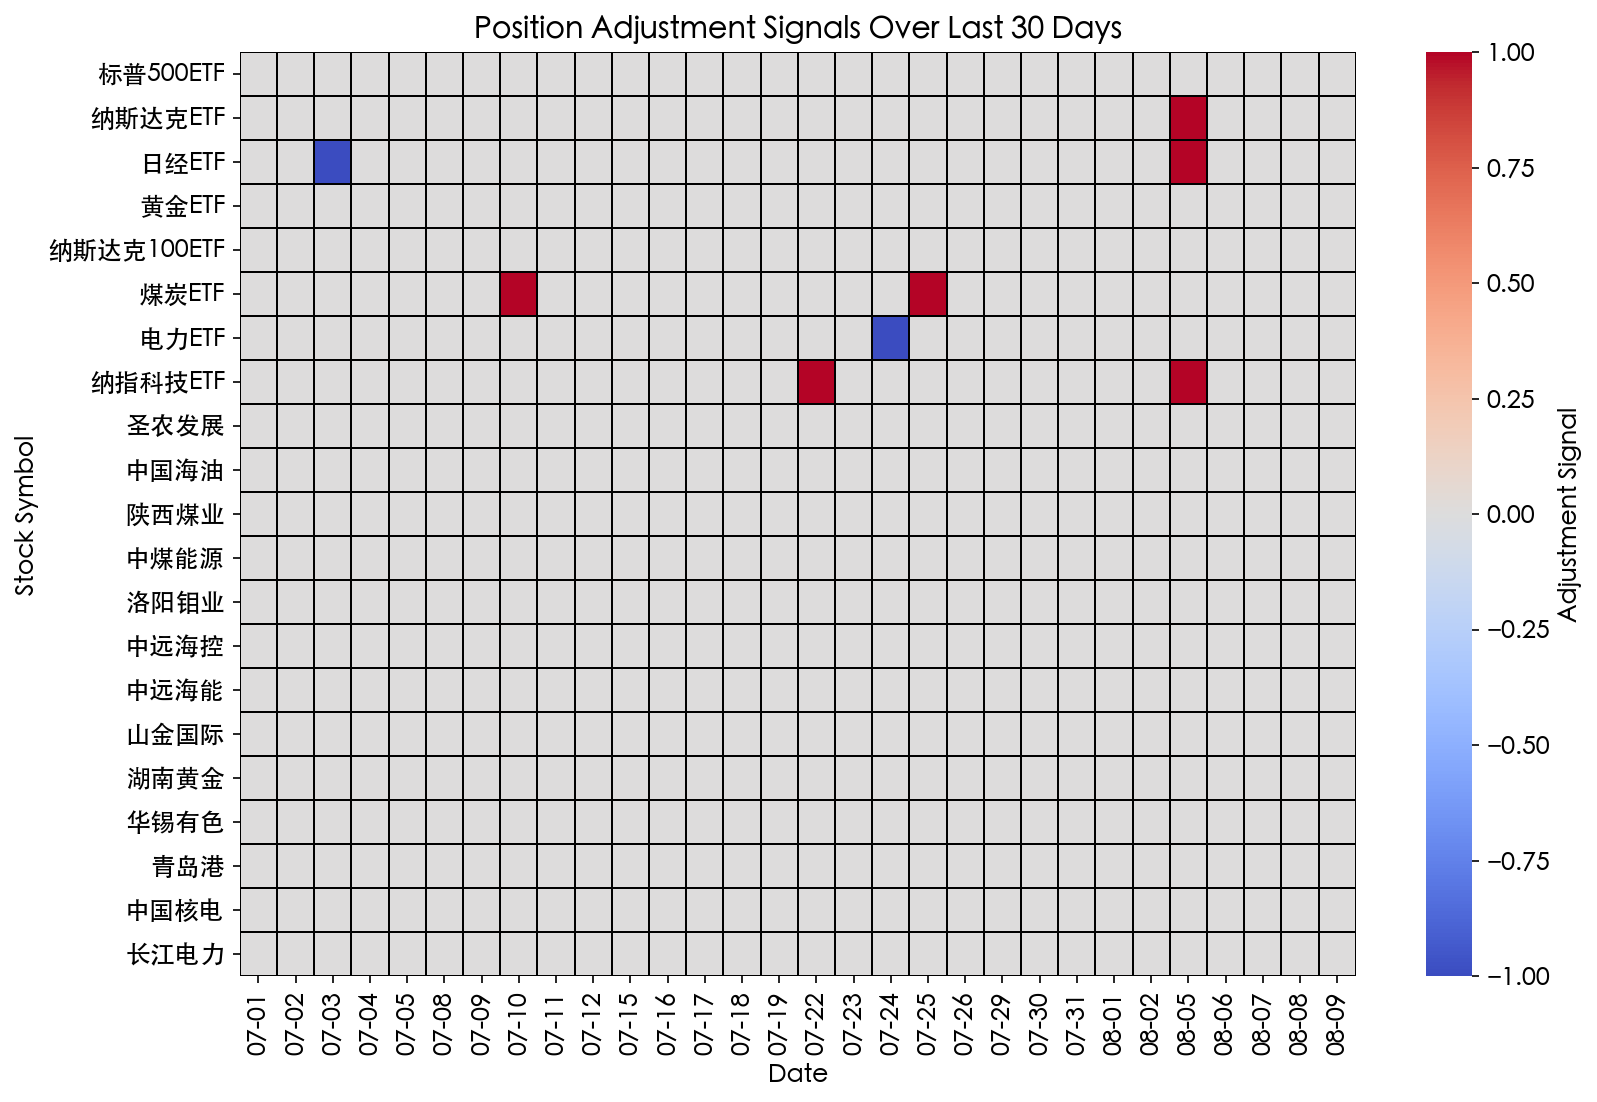

In [53]:
plot_adjustment_heatmap(dates, adjustments, stock_names)

In [54]:
display_position_table(stock_symbols, weights, adjustments)

21
21
21
   Stock Symbol  Current Position  Adjustment Signal
0     513500.SS          0.047619                0.0
1     513300.SS          0.047619                0.0
2     513520.SS          0.047619                0.0
3     518880.SS          0.047619                0.0
4     513110.SS          0.047619                0.0
5     515220.SS          0.047619                0.0
6     159611.SZ          0.047619                0.0
7     159509.SZ          0.047619                0.0
8     002299.SZ          0.047619                0.0
9     600938.SS          0.047619                0.0
10    601225.SS          0.047619                0.0
11    601898.SS          0.047619                0.0
12    603993.SS          0.047619                0.0
13    601919.SS          0.047619                0.0
14    600026.SS          0.047619                0.0
15    000975.SZ          0.047619                0.0
16    002155.SZ          0.047619                0.0
17    600301.SS          0.047619    